In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

Task 1 of Project 3.  Fully Connected Neural Network.

In [2]:
def run_task_1(training_images, testing_images, training_labels, testing_labels):
    #Construct network model
    task1_model = Sequential()
    task1_model.add(layers.Dense(units=1024,input_shape=(1024,), activation='tanh'))
    task1_model.add(layers.Dense(units=512, activation='sigmoid'))
    task1_model.add(layers.Dense(units=100, activation='relu'))
    task1_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
     
    #Create and fit the scaler to the data
    scaler = MinMaxScaler()
    scaled_training_images=scaler.fit_transform(training_images)
    scaled_testing_images=scaler.transform(testing_images)
    
    task1_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task1_model.fit(x=scaled_training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    
    cm = task1_model.predict(x=scaled_testing_images)
    
    #call model.evaluate for the final test loss and final test accuracy
    test_scores = task1_model.evaluate(x=scaled_testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    

    print(len(cm))
    sn.heatmap(cm, annot=False)
    
    return task1_model

In [3]:
#read in training and testing csv with labels for our data
training_labels = pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_df.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
testing_labels=testing_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

#read in images that we will be predicting on
training_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    testing_images[i-1]=im

Epoch 1/15
25/25 [==============================] - 2s 44ms/step - loss: 1.9440 - accuracy: 0.1825 - val_loss: 1.9265 - val_accuracy: 0.1750
Epoch 2/15
25/25 [==============================] - 1s 26ms/step - loss: 1.9203 - accuracy: 0.2037 - val_loss: 1.9235 - val_accuracy: 0.1300
Epoch 3/15
25/25 [==============================] - 1s 24ms/step - loss: 1.9174 - accuracy: 0.2125 - val_loss: 1.9127 - val_accuracy: 0.1800
Epoch 4/15
25/25 [==============================] - 1s 26ms/step - loss: 1.9159 - accuracy: 0.2125 - val_loss: 1.9067 - val_accuracy: 0.1750
Epoch 5/15
25/25 [==============================] - 1s 25ms/step - loss: 1.9034 - accuracy: 0.2163 - val_loss: 1.9198 - val_accuracy: 0.1750
Epoch 6/15
25/25 [==============================] - 1s 26ms/step - loss: 1.9050 - accuracy: 0.2037 - val_loss: 1.9126 - val_accuracy: 0.1750
Epoch 7/15
25/25 [==============================] - 0s 18ms/step - loss: 1.8955 - accuracy: 0.2237 - val_loss: 1.9000 - val_accuracy: 0.1950
Epoch 8/15
25

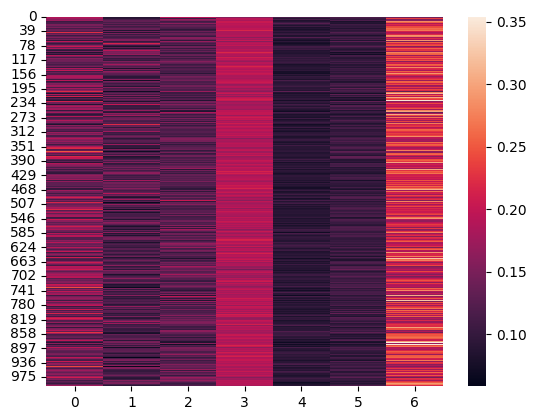

In [4]:
mod = run_task_1(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 2 of Project 3.   Small Convolutional Neural Network.

In [5]:
def run_task_2(training_images, testing_images, training_labels, testing_labels):
    #build the network
    task2_model = Sequential()
    task2_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task2_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task2_model.add(layers.Flatten())
    task2_model.add(layers.Dense(units=100, activation='relu'))
    task2_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    task2_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task2_model.fit(x=training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    
    cm = task2_model.predict(x=testing_images)
    
    test_scores = task2_model.evaluate(x=testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm, annot=False)
    

Epoch 1/15
25/25 [==============================] - 2s 70ms/step - loss: 1.9343 - accuracy: 0.1912 - val_loss: 1.9369 - val_accuracy: 0.1750
Epoch 2/15
25/25 [==============================] - 1s 57ms/step - loss: 1.9178 - accuracy: 0.2037 - val_loss: 1.9316 - val_accuracy: 0.1750
Epoch 3/15
25/25 [==============================] - 1s 54ms/step - loss: 1.9084 - accuracy: 0.2062 - val_loss: 1.9298 - val_accuracy: 0.1750
Epoch 4/15
25/25 [==============================] - 1s 54ms/step - loss: 1.9018 - accuracy: 0.2037 - val_loss: 1.9268 - val_accuracy: 0.1600
Epoch 5/15
25/25 [==============================] - 1s 47ms/step - loss: 1.8938 - accuracy: 0.2062 - val_loss: 1.9178 - val_accuracy: 0.1750
Epoch 6/15
25/25 [==============================] - 1s 55ms/step - loss: 1.8862 - accuracy: 0.2100 - val_loss: 1.9090 - val_accuracy: 0.1800
Epoch 7/15
25/25 [==============================] - 1s 39ms/step - loss: 1.8783 - accuracy: 0.2212 - val_loss: 1.8948 - val_accuracy: 0.1750
Epoch 8/15
25

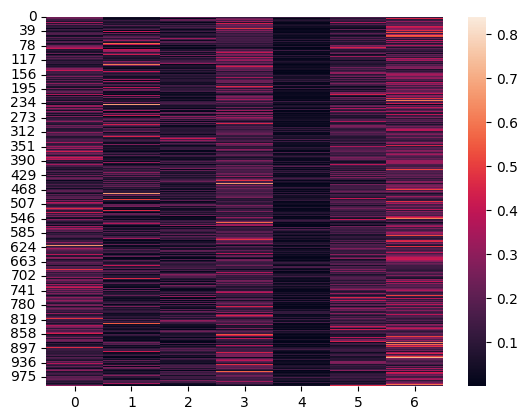

In [6]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
testing_labels=testing_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_2 = run_task_2(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 3 of Project 3.  Create our own convolutional layer.

In [7]:
def run_task_3(training_images, testing_images, training_labels, testing_labels):
    #build the network
    task3_model = Sequential()
    task3_model.add(layers.Conv2D(filters=40, kernel_size=(2,2), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', 
                                  strides=1, padding='valid'))
    task3_model.add(layers.MaxPooling2D(pool_size=(3,3)))
    task3_model.add(layers.Conv2D(filters=20, kernel_size=(4,4), activation='relu', 
                                  strides=1, padding='valid'))
    task3_model.add(layers.Flatten())
    task3_model.add(layers.Dense(units=100, activation='relu'))
    task3_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    task3_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task3_model.fit(x=training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    cm = task3_model.predict(x=testing_images)
    
    test_scores = task3_model.evaluate(x=testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm, annot=False)

Epoch 1/15
25/25 [==============================] - 2s 76ms/step - loss: 1.9481 - accuracy: 0.1388 - val_loss: 1.9452 - val_accuracy: 0.1600
Epoch 2/15
25/25 [==============================] - 2s 63ms/step - loss: 1.9427 - accuracy: 0.1488 - val_loss: 1.9424 - val_accuracy: 0.1550
Epoch 3/15
25/25 [==============================] - 1s 46ms/step - loss: 1.9391 - accuracy: 0.1963 - val_loss: 1.9402 - val_accuracy: 0.1800
Epoch 4/15
25/25 [==============================] - 1s 46ms/step - loss: 1.9362 - accuracy: 0.2013 - val_loss: 1.9385 - val_accuracy: 0.1750
Epoch 5/15
25/25 [==============================] - 1s 39ms/step - loss: 1.9338 - accuracy: 0.2025 - val_loss: 1.9372 - val_accuracy: 0.1750
Epoch 6/15
25/25 [==============================] - 1s 34ms/step - loss: 1.9317 - accuracy: 0.2037 - val_loss: 1.9361 - val_accuracy: 0.1750
Epoch 7/15
25/25 [==============================] - 1s 33ms/step - loss: 1.9300 - accuracy: 0.2037 - val_loss: 1.9353 - val_accuracy: 0.1750
Epoch 8/15
25

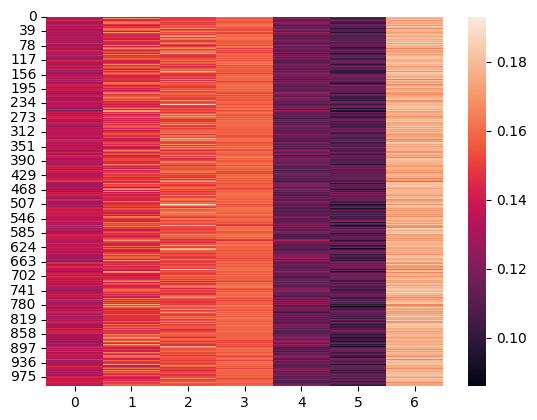

In [8]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
testing_labels=testing_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_3 = run_task_3(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Task 4 of Project 3.  Create Your Own Convolutional Neural Network On Both Tasks Simultaneously.

In [22]:

def run_task_4(training_images, testing_images, training_labels, testing_labels):
    #build the network
    x = layers.Input(shape=(32,32,1))
    
    hidden1 = layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1))(x)
    
    hidden2 = layers.MaxPooling2D(pool_size=(2,2))(hidden1)
    hidden3 = layers.Flatten()(hidden2)
    
    hidden_branch4 = layers.Dense(units=100, activation='relu')(hidden3)
    output1 = layers.Dense(units=2, activation='softmax')(hidden_branch4)
    
    hidden_branch5 = layers.Dense(units=100, activation='relu')(hidden3)
    output2 = layers.Dense(units=7, activation='softmax', )(hidden_branch5)
    task4_model = Model(inputs=x, outputs=[output1,output2])
    
    task4_model.summary()
    plot_model(task4_model)

    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
    
  
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_training_labels = enc.fit_transform(training_labels)
    encoded_testing_labels = enc.fit_transform(testing_labels)
    print('this is head: \n', encoded_testing_labels.head())
      
    task4_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task4_model.fit(x=training_images,y=encoded_training_labels, epochs=15, validation_split=0.2)
    cm = task4_model.predict(x=testing_images)
    
    test_scores = task4_model.evaluate(x=testing_images, y=encoded_testing_labels, verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    
    print(len(cm))
    sn.heatmap(cm, annot=False)

In [23]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)
#training_labels=training_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

testing_labels = pd.read_csv('fairface_label_val.csv', nrows=1000)
testing_labels=testing_labels.drop('file',axis=1) 
testing_labels=testing_labels.drop('service_test',axis=1)
testing_labels=testing_labels.drop('age',axis=1)
#testing_labels=testing_labels.drop('gender', axis=1)
#training_labels=training_labels.drop('race',axis=1)

#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_3 = run_task_4(training_images=training_images, testing_images=testing_images, training_labels=training_labels, testing_labels=testing_labels)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 40)   1040        ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 14, 14, 40)  0           ['conv2d_9[0][0]']               
                                                                                                  
 flatten_7 (Flatten)            (None, 7840)         0           ['max_pooling2d_8[0][0]']        
                                                                                            

AttributeError: 'numpy.ndarray' object has no attribute 'head'